## Import Libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from glob import glob


import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST/"

## Visualization

In [5]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 12565/12565 [01:34<00:00, 132.94it/s]


In [6]:
data.shape

(22564, 2)

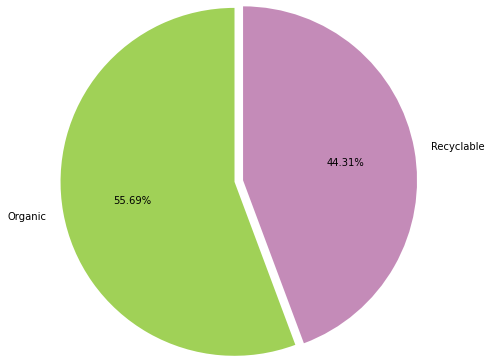

In [7]:
from collections import Counter
Counter(y_data)

colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

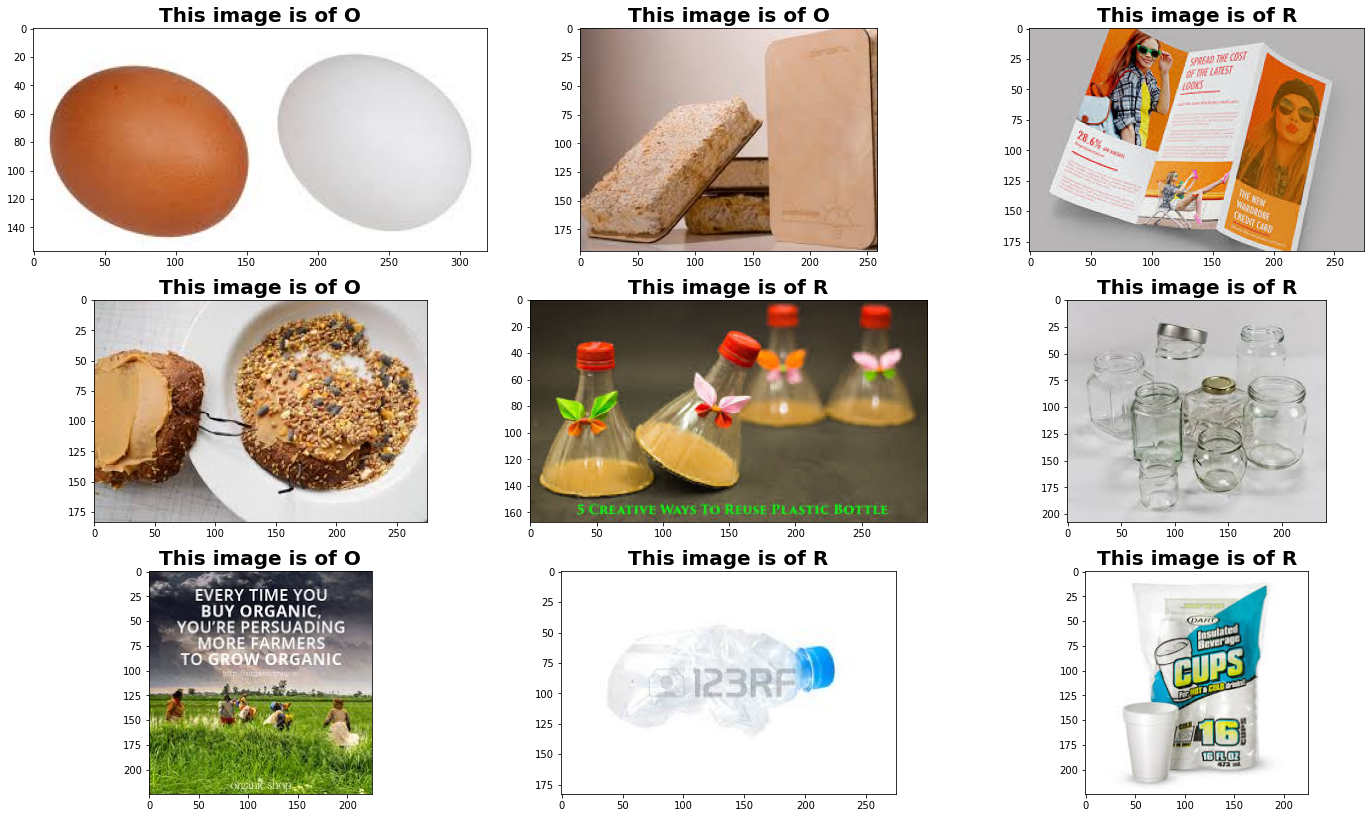

In [8]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

* O -> Organic
* R -> Recyclable

In [9]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


## Model Building

In [36]:
# building a CNN model
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))


# model compilation
model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

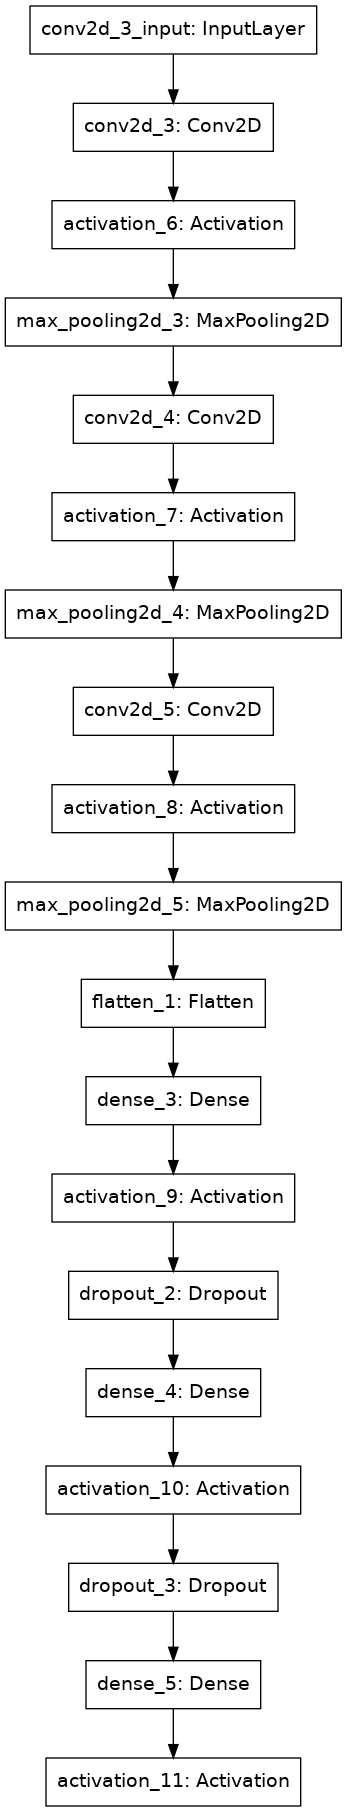

In [37]:
# model architecture
plot_model(model)

In [38]:
# model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_7 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)      

## Rescale Data

In [39]:
train_datagen = ImageDataGenerator(rescale= 1./255)

batch_size = 256
target_size= (224,224)
class_mode= "categorical"

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Add validation_split

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode=class_mode,
    subset='training'  # Specify subset as 'training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,  # Same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode=class_mode,
    subset='validation'  # Specify subset as 'validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


## Model Training

In [44]:
# early stopping and checkpointing
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Updated file format
]

In [49]:
# train the cnn model

history = model.fit(
         train_generator,
         epochs=30,
         validation_data=validation_generator,
         callbacks=callbacks
     )

Epoch 1/30
71/71 [==============================] - 98s 1s/step - loss: 0.6131 - accuracy: 0.7263 - val_loss: 0.4115 - val_accuracy: 0.8059
Epoch 2/30
71/71 [==============================] - 90s 1s/step - loss: 0.4157 - accuracy: 0.8325 - val_loss: 0.4308 - val_accuracy: 0.7921
Epoch 3/30
71/71 [==============================] - 90s 1s/step - loss: 0.3633 - accuracy: 0.8505 - val_loss: 0.4334 - val_accuracy: 0.8012
Epoch 4/30
71/71 [==============================] - 89s 1s/step - loss: 0.3453 - accuracy: 0.8673 - val_loss: 0.3779 - val_accuracy: 0.8533
Epoch 5/30
71/71 [==============================] - 90s 1s/step - loss: 0.3167 - accuracy: 0.8800 - val_loss: 0.3728 - val_accuracy: 0.8362
Epoch 6/30
71/71 [==============================] - 90s 1s/step - loss: 0.2995 - accuracy: 0.8814 - val_loss: 0.3640 - val_accuracy: 0.8475
Epoch 7/30
71/71 [==============================] - 90s 1s/step - loss: 0.2659 - accuracy: 0.8968 - val_loss: 0.3553 - val_accuracy: 0.8524
Epoch 8/30
71/71 [==

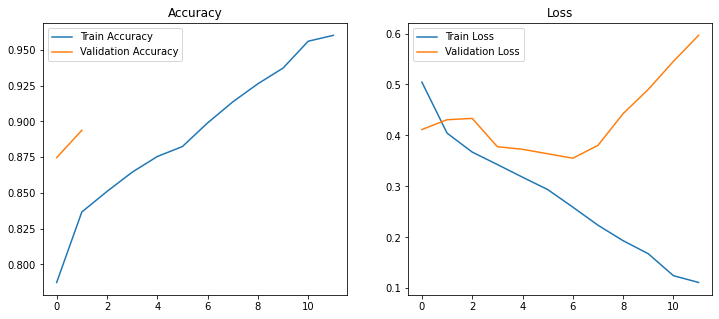

In [50]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

## Save the trained Model

In [51]:
# Save the trained model

model.save("Waste-Classification-CNN-Model.h5")

In [52]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("Waste-Classification-CNN-Model.h5")

## Model Prediction

In [53]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

This image -> Organic


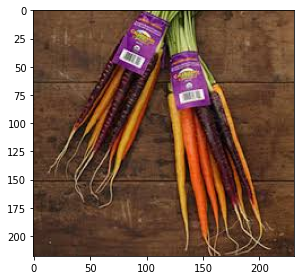

In [54]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

This image -> Organic


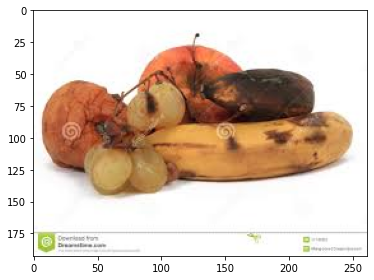

In [55]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TRAIN/O/O_10150.jpg")
predict_func(test_img)

## Model Evaluation

In [57]:
# Prepare Test Data

test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False  # Do not shuffle so that labels remain aligned
)

Found 2513 images belonging to 2 classes.


In [58]:
accuracy = model.evaluate_generator(test_generator)
print("Accuracy:", accuracy)

Accuracy: [0.2726968824863434, 0.8965380191802979]


In [63]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the labels for test data
Y_pred = model.predict(test_generator) 

# Convert probabilities to class labels
y_pred = np.argmax(Y_pred, axis=1)  

# Get the true class labels from the test generator
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_true, y_pred)
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[1356   45]
 [ 215  897]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1401
           1       0.95      0.81      0.87      1112

    accuracy                           0.90      2513
   macro avg       0.91      0.89      0.89      2513
weighted avg       0.90      0.90      0.90      2513



## Testing on Real Images

This image -> Organic


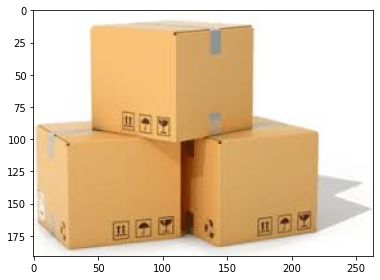

In [59]:
test_img = cv2.imread("/kaggle/input/input-samples/cardboard.jpeg")
predict_func(test_img)

This image -> Organic


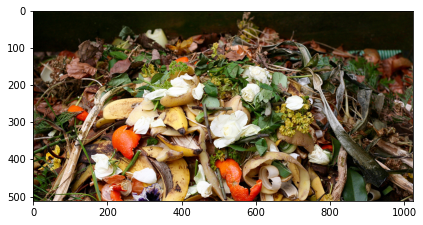

In [60]:
test_img = cv2.imread("/kaggle/input/input-samples/food-waste.jpg")
predict_func(test_img)

This image -> Recyclable


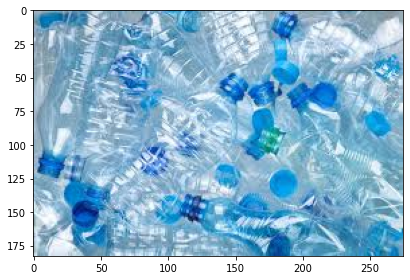

In [61]:
test_img = cv2.imread("/kaggle/input/input-samples/plastic.jpeg")
predict_func(test_img)

This image -> Organic


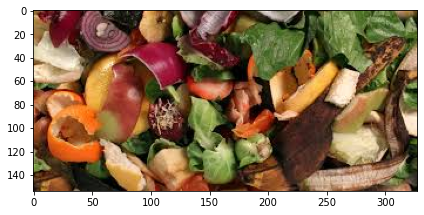

In [62]:
test_img = cv2.imread("/kaggle/input/input-samples/organic.jpeg")
predict_func(test_img)

## Thank You